In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/truncated-enron/enron_test.csv


In [2]:
import datetime
df = pd.read_csv('/kaggle/input/truncated-enron/enron_test.csv')
df.head(5)

,Date,From,To,Subject,content,new_date
0,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",frozenset({'phillip.allen@enron.com'}),frozenset({'tim.belden@enron.com'}),NaN,Here is our forecast\n\n,2001-05-14 23:39:00
1,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",frozenset({'phillip.allen@enron.com'}),frozenset({'john.lavorato@enron.com'}),Re:,Traveling to have a business meeting takes the...,2001-05-04 20:51:00
2,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",frozenset({'phillip.allen@enron.com'}),frozenset({'leah.arsdall@enron.com'}),Re: test,test successful. way to go!!!,2000-10-18 10:00:00
3,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",frozenset({'phillip.allen@enron.com'}),frozenset({'randall.gay@enron.com'}),NaN,"Randy,\n\n Can you send me a schedule of the s...",2000-10-23 13:13:00
4,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",frozenset({'phillip.allen@enron.com'}),frozenset({'greg.piper@enron.com'}),Re: Hello,Let's shoot for Tuesday at 11:45.,2000-08-31 12:07:00


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      1000 non-null   object
 1   From      1000 non-null   object
 2   To        995 non-null    object
 3   Subject   698 non-null    object
 4   content   1000 non-null   object
 5   new_date  1000 non-null   object
dtypes: object(6)
memory usage: 47.0+ KB


### Let us first convert the Date column to a datetime format. We see that the Date column is datetime information as per the Pacific Day Time zone. Since we already have a column "new_date" that captures the utc datetime information. We can have the "Date" column in PDT. We simply localize it as follows:-

In [4]:
df['new_date'] = df['Date'].apply(lambda x: pd.to_datetime(x,infer_datetime_format=True).tz_convert(None))
df['new_date'] = pd.to_datetime(df['new_date'])
df.rename(columns={'new_date':'datetime_utc'},inplace=True)
df['Date'] = df['Date'].apply(lambda x: (pd.to_datetime(x)).tz_localize(None))

In [5]:
## Let us only consider the 'Content' column for topic modelling and exlude 'Subject'. 
##As 'Subject' is a shortened versions of the content
analysis_df = df[['Date','From','To','content']].dropna().copy()
analysis_df.reset_index(drop=True,inplace=True)

In [6]:
analysis_df.head(5)

,Date,From,To,content
0,2001-05-14 16:39:00,frozenset({'phillip.allen@enron.com'}),frozenset({'tim.belden@enron.com'}),Here is our forecast\n\n
1,2001-05-04 13:51:00,frozenset({'phillip.allen@enron.com'}),frozenset({'john.lavorato@enron.com'}),Traveling to have a business meeting takes the...
2,2000-10-18 03:00:00,frozenset({'phillip.allen@enron.com'}),frozenset({'leah.arsdall@enron.com'}),test successful. way to go!!!
3,2000-10-23 06:13:00,frozenset({'phillip.allen@enron.com'}),frozenset({'randall.gay@enron.com'}),"Randy,\n\n Can you send me a schedule of the s..."
4,2000-08-31 05:07:00,frozenset({'phillip.allen@enron.com'}),frozenset({'greg.piper@enron.com'}),Let's shoot for Tuesday at 11:45.


# ------------------------------------------ PART 1 ------------------------------------

## As we can see in the data above, we will be using the content column text to do some topic modelling. This will help us to better understand what kind of topics are mainly discussed in the emails.


### To achieve this, we need to begin with some NLP pre-processing steps on the content column to prepare the text for semantic Analysis. We take help of the popular NLTK library as follows:

In [7]:
# Unsupervised Learning
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA

#NLP
import re
import gensim
from gensim import corpora
from gensim.models import TfidfModel
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string


## to visualize LDA 
import pyLDAvis
import pyLDAvis.gensim

## Other
import matplotlib.pyplot as plt

### Extra - not used libraries
#from nltk.tokenize.regexp import RegexpTokenizer
#from subprocess import check_output
#from nltk.stem.porter import PorterStemmer

# from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA
# from sklearn.lda import LDA
# from sklearn.decomposition import LatentDirichletAllocation

/opt/conda/lib/python3.7/site-packages/past/types/oldstr.py:36: DeprecationWarning: invalid escape sequence \d
  """


## We define a helper function to clean the content column that removes unnecessary punctuations, stop words, numbers etc. We then use word Lemmatization to convert inflectional forms of same words to their common base/root form.

### example: words like 'democracy', 'democratic', and 'democratization' should be treated as samiliar. Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma .

In [8]:
print(stopwords.words('english')) ### List of all the default stop wordss we will be removing

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [9]:
def clean(text):
    stop = set(stopwords.words('english'))
    stop.update(("to","cc","subject","http","from","sent"))
    exclude = set(string.punctuation) 
    lemma = WordNetLemmatizer()
    
    text=text.rstrip()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    stop_free = " ".join([i for i in text.lower().split() if((i not in stop) and (not i.isdigit()))])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    #stem = " ".join(porter.stem(token) for token in normalized.split())
    
    return normalized

In [10]:
# Apply the helper function to on the content array and get the cleaned corpus that we use to define the vocabulary
text_clean=[]
for text in analysis_df['content']:
    text_clean.append(clean(text).split())

In [11]:
print(text_clean[1])
print(analysis_df['content'].loc[1])

['traveling', 'business', 'meeting', 'take', 'fun', 'trip', 'especially', 'prepare', 'presentation', 'would', 'suggest', 'holding', 'business', 'plan', 'meeting', 'take', 'trip', 'without', 'formal', 'business', 'meeting', 'would', 'even', 'try', 'get', 'honest', 'opinion', 'whether', 'trip', 'even', 'desired', 'necessary', 'far', 'business', 'meeting', 'think', 'would', 'productive', 'try', 'stimulate', 'discussion', 'across', 'different', 'group', 'working', 'often', 'presenter', 'speaks', 'others', 'quiet', 'waiting', 'turn', 'meeting', 'might', 'better', 'held', 'round', 'table', 'discussion', 'format', 'suggestion', 'go', 'austin', 'play', 'golf', 'rent', 'ski', 'boat', 'jet', 'ski', 'flying', 'somewhere', 'take', 'much', 'time']
Traveling to have a business meeting takes the fun out of the trip.  Especially if you have to prepare a presentation.  I would suggest holding the business plan meetings here then take a trip without any formal business meetings.  I would even try and ge

### Let us add some Bigrams and Trigrams into the mix.

In [12]:
## BIGRAMS AND TRIGRAMS
bigrams_phrases = gensim.models.Phrases(text_clean,min_count=5,threshold=50)
trigram_phrases = gensim.models.Phrases(bigrams_phrases[text_clean],threshold=50)

bigram = gensim.models.phrases.Phraser(bigrams_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return [bigram[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram[bigram[doc]] for doc in texts]

data_bigrams = make_bigrams(text_clean)
data_bigrams_trigrams = make_trigrams(data_bigrams)

print(data_bigrams_trigrams[993])

['jacques', 'think', 'reached', 'agreement', 'george_larry', 'pick', 'item', 'value', 'pay', 'fee', 'time', 'look', 'able', 'use', 'everything', 'done', 'engineering', 'architecture', 'survey', 'appraisal', 'one', 'point', 'unclear', 'claim', 'extension', 'paid', 'applied', 'purchase', 'price', 'land', 'like', 'earnest', 'money', 'would', 'applied', 'looked', 'closing_statement', 'see', 'applied', 'purchase', 'price', 'help', 'clear', 'assuming', 'clear', 'need', 'get', 'property', 'released', 'keith', 'concerned', 'taking', 'bishop_corner', 'partnership', 'risk', 'could', 'undisclosed', 'liability', 'hand', 'conveyance', 'partnership', 'would', 'time', 'money', 'saver', 'clean', 'inclination', 'call', 'soon', 'chance', 'review', 'phillip']


## Now that we have clean documents of each email, we can do latent sematic Analysis by using Tf-idf vectorization of email texts followed by using unsupervised algorithms like K-Means Clustering to identify the optimum number of clusters that best separates the data in Least Square sense.

In [13]:
## Let us keep this column later for performing LDA
analysis_df['content_cleaned'] = pd.Series(data_bigrams_trigrams,index=analysis_df.index)

In [14]:
eng_stopwords = set(stopwords.words('english'))
def clean_text(text):
    #text = BeautifulSoup(text, 'html.parser').get_text()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    words = text.lower().split()
    words = [w for w in words if w not in eng_stopwords]
    return ' '.join(words)

analysis_df["clean_content"]=analysis_df.content.apply(clean_text)

wordvector = TfidfVectorizer(analyzer='word', stop_words='english', max_df=0.4, min_df=5)
wordvector_fit = wordvector.fit_transform(analysis_df['clean_content'])
feature = wordvector.get_feature_names()

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [15]:
wordvector_fit_2d = wordvector_fit.todense()

In [16]:
wordvector_fit_2d.shape

(995, 2439)

### Now I wanted to find out what the top keywords were in those emails. I made this function doing exactly that:

In [17]:
def top_tfidf_feats(row, features, top_n=20):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df

def top_feats_in_doc(X, features, row_id, top_n=25):
    row = np.squeeze(np.asarray(X[row_id]))
    return top_tfidf_feats(row, features, top_n)

print(top_feats_in_doc(wordvector_fit_2d, feature, 20, 10))

    features     score
0    october  0.424702
1     second  0.385953
2    payment  0.379968
3     brenda  0.353033
4      check  0.343167
5       mail  0.286046
6        use  0.267544
7        let  0.265310
8       know  0.245163
9  financail  0.000000


In [18]:
analysis_df['clean_content'].iloc[20]

'brenda please use second check october payment already tossed let know mail another phillip'

### All making sense if you look into the corresponding email.

'brenda please use **second** check **october payment** already tossed let know mail another phillip'

### The next step was writing a function to get the top terms out of all the emails.

In [19]:
def top_mean_feats(X, features,grp_ids=None, min_tfidf=0.1, top_n=25):
    if grp_ids:
        D = np.asarray(X[grp_ids])
    else:
        D = np.asarray(X)
        
    D[D < min_tfidf] = 0
    
    tfidf_means = np.mean(D, axis=0)
    
    return top_tfidf_feats(tfidf_means, features, top_n)

#### Returning the top terms out of all the emails.

In [20]:
print(top_mean_feats(wordvector_fit_2d, feature, top_n=10))

  features     score
0      ect  0.088610
1      hou  0.048033
2    enron  0.044252
3      com  0.032715
4       pm  0.015916
5      gas  0.014635
6    email  0.013626
7     need  0.013089
8     lucy  0.013084
9   thanks  0.012055


## Clustering with kmeans

In [21]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k,max_iter=50,init='k-means++',n_init=10)
    km = km.fit(wordvector_fit_2d)
    Sum_of_squared_distances.append(km.inertia_)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn

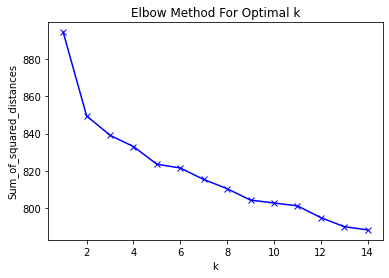

In [22]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


### We see that the curve elbows at k = 4. We can remember this piece of imformation for further topic modelling

In [23]:
pca = PCA(n_components=2).fit(wordvector_fit_2d)
datapoint = pca.transform(wordvector_fit_2d)

N = 3
clf = KMeans(n_clusters=N, 
            max_iter=300, 
            init='k-means++', 
            n_init=10)
labels = clf.fit_predict(wordvector_fit_2d)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


In [24]:
analysis_df['cluster'] = pd.Series(labels,index=analysis_df.index)

In [25]:
analysis_df.tail(5)

,Date,From,To,content,content_cleaned,clean_content,cluster
990,2001-03-19 01:36:00,frozenset({'phillip.allen@enron.com'}),frozenset({'jacquestc@aol.com'}),"Jacques,\n\nStill trying to close the loop on ...","[jacques, still, trying, close, loop, extensio...",jacques still trying close loop extensions ass...,1
991,2001-03-19 00:45:00,frozenset({'phillip.allen@enron.com'}),frozenset({'llewter@austin.rr.com'}),"Larrry,\n\nI realize you are disappointed abou...","[larrry, realize, disappointed, project, desir...",larrry realize disappointed project desire lef...,1
992,2000-12-06 08:04:00,frozenset({'phillip.allen@enron.com'}),frozenset({'pallen70@hotmail.com'}),---------------------- Forwarded by Phillip K ...,"[forwarded, phillip, k, allen, hou, ect, pm, l...",forwarded phillip k allen hou ect pm lucy gonz...,2
993,2001-03-16 04:28:00,frozenset({'phillip.allen@enron.com'}),frozenset({'jacquestc@aol.com'}),"Jacques,\n\nI think we reached an agreement wi...","[jacques, think, reached, agreement, george_la...",jacques think reached agreement george larry p...,1
994,2001-03-15 07:42:00,frozenset({'phillip.allen@enron.com'}),frozenset({'matt.smith@enron.com'}),---------------------- Forwarded by Phillip K ...,"[forwarded, phillip, k, allen, hou, ect, pm, m...",forwarded phillip k allen hou ect pm mike grig...,0


In [26]:
np.unique(labels)

array([0, 1, 2], dtype=int32)

### Let us use PCA to get low level projects of the data for visualization purpose

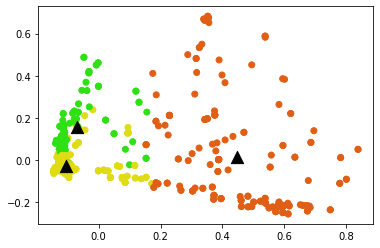

In [27]:
label = ["#e05f14", "#e0dc14", "#2fe014"]#,"#14d2e0","#8455d3","#b13825","#828c45","#0c0c04"]
color = [label[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

centroids = clf.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

### Because I now know which emails the machine assigned to each cluster, I was able to write a function that extracts the top terms per cluster.

In [28]:
def top_feats_per_cluster(X, y, features, min_tfidf=0.1, top_n=25):
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label) 
        feats_df = top_mean_feats(X,features,ids,min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [29]:
dfs = top_feats_per_cluster(wordvector_fit_2d,labels,feature)

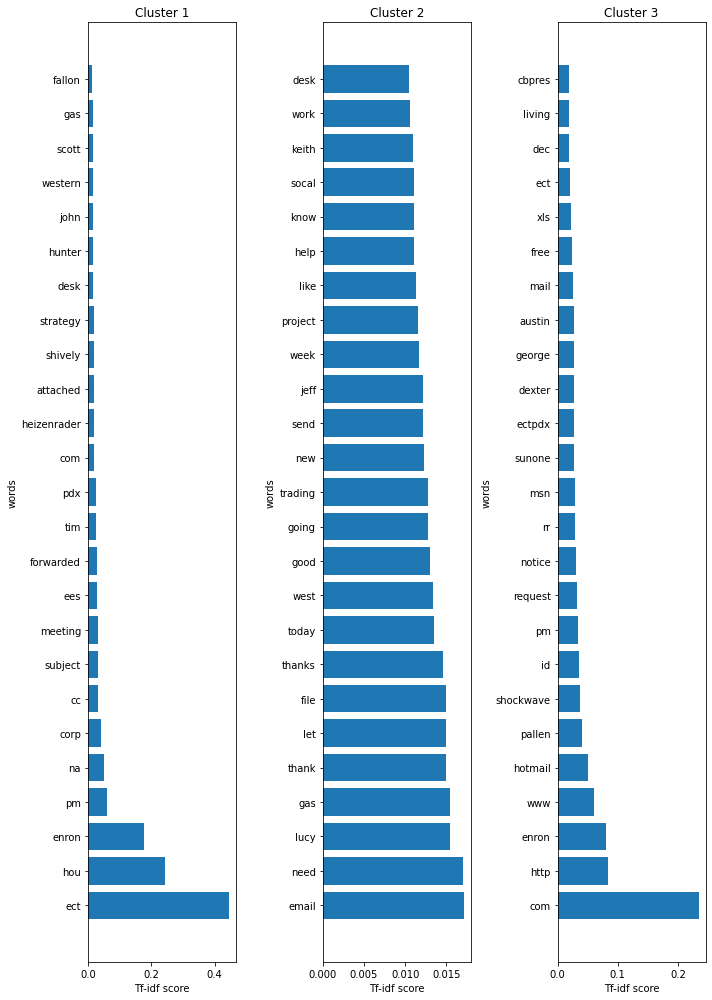

In [30]:
plt.figure(figsize=(10,14))
plt.title("Top words per cluster")

for i in range(3):
    plt.subplot(1,3,i+1)
    plt.barh(dfs[i]['features'],dfs[i]['score'])
    plt.title('Cluster '+str(i+1))
    plt.ylabel('words')
    plt.xlabel('Tf-idf score')
    
plt.tight_layout()
    
plt.show()

# Another way of topic modelling can be done using Latent Dirichlet Allocation

## Now that we know the optimum number of clusters.Let us clean the data further by removing some unwanted words that occur a lot and dont necessarily mean anything. Gensim's tfidf methods can help us remove words with a low tfidf value.

In [31]:
## TF-IDF Removal

dictionary = corpora.Dictionary(data_bigrams_trigrams) ## Create the dictionary that indicates the vocab across all email 
## contents with trigrams & bigrams now added to the text

texts = data_bigrams_trigrams


text_term_matrix = [dictionary.doc2bow(text) for text in texts] ## Convert each email content as BOW object - list(word_id,freq) for 
##each doc
print('Vocab Size:',len(dictionary))

tfidf = TfidfModel(text_term_matrix,id2word=dictionary)

low_value = 0.03

words = []
words_missing_in_tfidf = []

for i in range(0, len(text_term_matrix)):
    bow = text_term_matrix[i]
    low_value_words = [] #reinitialize to be safe.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    
    drops = low_value_words+words_missing_in_tfidf ## 
    
    for item in drops:
        words.append(dictionary[item])   
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf score 0 will be missing
    
    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    text_term_matrix[i] = new_bow

print('Removed Size:',len(set(words))) 

Vocab Size: 7456
Removed Size: 3415


## We are now ready to apply Latent Dirichlet Allocation for topic modelling

In [32]:
#Lda = gensim.models.ldamodel.LdaModel
ldamodel = gensim.models.ldamodel.LdaModel(text_term_matrix, num_topics=3,
                                           id2word = dictionary, passes=30,random_state=100,update_every=1,chunksize=100,alpha="auto")
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel,text_term_matrix,dictionary,mds="mmds",R=30)

/opt/conda/lib/python3.7/site-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


### Visualize the content data

In [33]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.063030  0.213023       1        1  43.531807
1      0.272388 -0.106398       2        1  33.574034
2     -0.209359 -0.106625       3        1  22.894158, topic_info=            Term         Freq        Total Category  logprob  loglift
147          ect  4061.000000  4061.000000  Default  30.0000  30.0000
87         enron  3021.000000  3021.000000  Default  29.0000  29.0000
165          hou  2266.000000  2266.000000  Default  28.0000  28.0000
1548  enronxgate   492.000000   492.000000  Default  27.0000  27.0000
512           na   435.000000   435.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
58         would    55.995625   347.954216   Topic3  -5.5514  -0.3525
321         desk    37.456593    64.550410   Topic3  -5.9535   0.9300
381        issue    38.690271    78.089935   Topic3  -5.9211   0.7720
24       meeting    40.248079   153.879336   Topic3  -5.8816   0.1332
94          list    38.662795   100.580835   Topic3  -5.9218   0.5182

[193 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
5442      3  0.948472              aes
2137      2  0.968403  alan_comnes_pdx
269       2  0.958931   allan_severude
84        1  0.302265            allen
84        2  0.696889            allen
...     ...       ...              ...
233       1  0.992392             work
58        1  0.839191            would
58        3  0.160941            would
2748      3  0.978956             wscc
1098      1  0.988893            yahoo

[244 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

# ------------------------------ END OF PART 1 --------------------------------------

In [34]:
analysis_df.head(10)

,Date,From,To,content,content_cleaned,clean_content,cluster
0,2001-05-14 16:39:00,frozenset({'phillip.allen@enron.com'}),frozenset({'tim.belden@enron.com'}),Here is our forecast\n\n,[forecast],forecast,1
1,2001-05-04 13:51:00,frozenset({'phillip.allen@enron.com'}),frozenset({'john.lavorato@enron.com'}),Traveling to have a business meeting takes the...,"[traveling, business, meeting, take, fun, trip...",traveling business meeting takes fun trip espe...,1
2,2000-10-18 03:00:00,frozenset({'phillip.allen@enron.com'}),frozenset({'leah.arsdall@enron.com'}),test successful. way to go!!!,"[test, successful, way, go]",test successful way go,1
3,2000-10-23 06:13:00,frozenset({'phillip.allen@enron.com'}),frozenset({'randall.gay@enron.com'}),"Randy,\n\n Can you send me a schedule of the s...","[randy, send, schedule, salary, level, everyon...",randy send schedule salary level everyone sche...,1
4,2000-08-31 05:07:00,frozenset({'phillip.allen@enron.com'}),frozenset({'greg.piper@enron.com'}),Let's shoot for Tuesday at 11:45.,"[let, shoot, tuesday]",let shoot tuesday,1
5,2000-08-31 04:17:00,frozenset({'phillip.allen@enron.com'}),frozenset({'greg.piper@enron.com'}),"Greg,\n\n How about either next Tuesday or Thu...","[greg, either, next, tuesday, thursday, phillip]",greg either next tuesday thursday phillip,1
6,2000-08-22 07:44:00,frozenset({'phillip.allen@enron.com'}),"frozenset({'john.shafer@enron.com', 'david.l.j...",Please cc the following distribution list with...,"[please, following, distribution, list, update...",please cc following distribution list updates ...,2
7,2000-07-14 06:59:00,frozenset({'phillip.allen@enron.com'}),frozenset({'joyce.teixeira@enron.com'}),any morning between 10 and 11:30,[morning],morning,1
8,2000-10-17 02:26:00,frozenset({'phillip.allen@enron.com'}),frozenset({'mark.scott@enron.com'}),1. login: pallen pw: ke9davis\n\n I don't thi...,"[login, pallen, pw, ke, davis, think, required...",login pallen pw ke davis think required isp st...,1
9,2000-10-16 06:44:00,frozenset({'phillip.allen@enron.com'}),frozenset({'zimam@enron.com'}),---------------------- Forwarded by Phillip K ...,"[forwarded, phillip, k, allen, hou, ect, pm, b...",forwarded phillip k allen hou ect pm buckner b...,1


# ------------------------------PART 2 ---------------------------------

# Let us see some basic Temporal Analysis & Trends using Emails and the Date Column

### String Manipulation to convert the emails from a frozenset to List of emails.

In [35]:
analysis_df['From'] = analysis_df['From'].str.replace('frozenset', '')
analysis_df['From'] = analysis_df['From'].str.replace('[({})]','')
analysis_df['From'] = analysis_df['From'].str.split(',')
analysis_df['From'] = analysis_df['From'].apply(lambda x: ''.join(x))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [36]:
analysis_df['To'] = analysis_df['To'].str.replace('frozenset', '')
analysis_df['To'] = analysis_df['To'].str.replace('[({})]','')
analysis_df['To'] = analysis_df['To'].str.split(',')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


## Let us add year, month, Day of Week, weekday/weekend flag to our dataframe for Temporal Analysis

In [37]:
analysis_df['year'] = analysis_df['Date'].dt.year
analysis_df['month'] = analysis_df['Date'].dt.month
analysis_df['dow'] = analysis_df['Date'].dt.dayofweek
analysis_df['is_weekend'] = analysis_df.dow.apply(lambda x: 1 if x in [5,6] else 0)
analysis_df['Just Date'] = analysis_df.Date.dt.date

### Out going Emails Analysis

In [38]:
analysis_df['From'].value_counts() ### Out going data is clearly skewed

'phillip.allen@enron.com'                    944
'critical.notice@enron.com'                    5
'ina.rangel@enron.com'                         4
'announce@inbox.nytimes.com'                   2
'ei_editor@ftenergy.com'                       2
'aod@newsdata.com'                             2
'webmaster@earnings.com'                       2
'sarah.novosel@enron.com'                      2
'jsmith@austintx.com'                          2
'kim.ward@enron.com'                           1
'grensheltr@aol.com'                           1
'yahoo-delivers@yahoo-inc.com'                 1
'perfmgmt@enron.com'                           1
'alyse.herasimchuk@enron.com'                  1
'matt@fastpacket.net'                          1
'lisa.jacobson@enron.com'                      1
'christi.nicolay@enron.com'                    1
'richard.shapiro@enron.com'                    1
'gthorse@keyad.com'                            1
'tiffany.miller@enron.com'                     1
'philip.polsky@enron

### Only Phillip sent out going emails on the weekend. As shown below:-

In [39]:
analysis_df[analysis_df.is_weekend == 1]['From'].value_counts()

'phillip.allen@enron.com'    20
Name: From, dtype: int64


### First lets see the Monthly average outgoing calls data 

In [40]:
analysis_df_2 = analysis_df.groupby(by=['year','month','From']).size().reset_index(name="Total Month Calls")
analysis_df_2.sort_values(by=['Total Month Calls'],ascending=[False],inplace=True)
analysis_df_2.reset_index(drop=True,inplace=True)

In [41]:
analysis_df_2.head(4)

,year,month,From,Total Month Calls
0,2001,4,'phillip.allen@enron.com',129
1,2000,8,'phillip.allen@enron.com',101
2,2001,3,'phillip.allen@enron.com',89
3,2000,9,'phillip.allen@enron.com',84


### As we can see below, On an average, Philip Allen has the highest Monthly average outgoing Calls, followed by emails from:-
### 'critical.notice@enron.com', 'aod@newsdata.com', 'jsmith@austintx.com'


In [42]:
df_month_avg_outgoing_user = analysis_df_2.groupby(by=['From']).agg({'Total Month Calls':'mean'}).reset_index()
df_month_avg_outgoing_user.rename(columns={'Total Month Calls':'Avg. Monthly Calls'},inplace=True)
df_month_avg_outgoing_user['Avg. Monthly Calls'] = df_month_avg_outgoing_user['Avg. Monthly Calls'].round(0)
df_month_avg_outgoing_user.sort_values(by=['Avg. Monthly Calls'],ascending=False,inplace=True)
df_month_avg_outgoing_user.head(10)

,From,Avg. Monthly Calls
25,'phillip.allen@enron.com',50.0
9,'critical.notice@enron.com',5.0
3,'aod@newsdata.com',2.0
16,'jsmith@austintx.com',2.0
30,'sarah.novosel@enron.com',2.0
0,'1.11913372.-2@multexinvestornetwork.com',1.0
29,'rob_tom@freenet.carleton.ca',1.0
23,'perfmgmt@enron.com',1.0
24,'philip.polsky@enron.com',1.0
26,'public.relations@enron.com',1.0


## As we can see that the outgoing data is very Skewed so doesn't make sense to look more temporal analysis of out going emails. Most outgoing emails are done by Philip Allen

In [43]:
analysis_df_dow = analysis_df.groupby(by=['From','Just Date','dow']).size().reset_index(name='weekly total')
analysis_df_dow_avg = analysis_df_dow.groupby(by=['From','dow']).agg({'weekly total':'mean'}).reset_index()
analysis_df_dow_avg.rename(columns={'weekly total':'Avg. weekly calls'},inplace=True)
analysis_df_dow_avg.sort_values(by=['Avg. weekly calls'],ascending=False,inplace=True)
analysis_df_dow_avg_top = analysis_df_dow_avg.groupby(by=['From']).head(1).reset_index(drop=True)

In [44]:
analysis_df_dow_avg_top.iloc[0]

From                 'phillip.allen@enron.com'
dow                                          0
Avg. weekly calls                     4.384615
Name: 0, dtype: object

### ^^ As we can see above, Phillip Allen, on an average, sends Highest volume of composed emails on a Monday as compared to any other workday.